In [175]:
%load_ext autoreload
%autoreload 2
from MVC_env import MVC_environement
from DQN_network import embedding_network
import numpy as np
import networkx as nx
import math
import torch
from tqdm import tqdm_notebook as tqdm
import pickle
import random
import itertools
def pickle_save(data,file_name):
    with open(file_name,'wb') as f:
        pickle.dump(data , f)
def pickle_load(file_name):
    with open(file_name,'rb') as f:
        return pickle.load(f)


np.random.seed(19960214)
random.seed(19960214)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
from collections import namedtuple

experience = namedtuple("experience" , ['graph','Xv','action','reward','next_Xv','is_done'])

class replay_buffer():
    def __init__(self , max_size):
        self.buffer = np.zeros(  [max_size],dtype = experience)
        self.max_size = max_size
        self.size = 0
        self.idx = -1
    def push(self , new_exp):
        if(self.size >= self.max_size):
            self.idx = (self.idx+1) % self.max_size
        else:
            self.idx = self.idx + 1
            self.size += 1
        
        self.buffer[self.idx] = new_exp
    
    def sample(self , batch_size):
        batch = np.random.choice(np.arange(self.size) , size = batch_size , replace=False)
        
        return self.buffer[[batch]]
    


In [15]:
def approximate_algo(env):
    edge_list = env.edges[:]
    
    C =  set()
    #print(len(edge_list))
    while( len(edge_list) > 0):
        #print(len(edge_list))
        e = edge_list[-1]
        u,v = e
        C.add(u)
        C.add(v)
        to_remove = []
        for ed in edge_list:
            if (u in ed) or (v in ed):
                to_remove.append(ed)
        for ed in to_remove:
            edge_list.remove(ed)
    
    for v in C:
        env.take_action(v)
    
    return C

g = nx.erdos_renyi_graph(n = 200 , p = 0.1)
#g = nx.barabasi_albert_graph(n=100,m=10)
env = MVC_environement(g)
C = approximate_algo(env)
len(C)

192

In [17]:
validation_graph_ba = []
for i in range(50):
    #p = np.random.uniform(0.05,0.)
    #g = nx.erdos_renyi_graph(n = 20 , p = 0.15)
    g = nx.barabasi_albert_graph(graph_size , 4)
    validation_graph_ba.append(g)

In [56]:
nx.density(validation_graph[0]),nx.density(validation_graph_another[0])

(0.14530612244897959, 0.3722448979591837)

In [57]:
res = []
for g in validation_graph:
    env = MVC_environement(g)
    C = approximate_algo(env)
    res.append(len(C))
approx_val = sum(res)/len(res)

In [58]:
res = []
for g in validation_graph_another:
    env = MVC_environement(g)
    C = approximate_algo(env)
    res.append(len(C))
approx_val_another = sum(res)/len(res)
approx_val,approx_val_another

(45.36, 38.0)

In [29]:
def validation(dqn , validation_graph):
    objective_vals = []
    for g in validation_graph:
        env = MVC_environement(g)
        Xv , graph = env.reset_env()
        graph = torch.unsqueeze(graph,  0)
        Xv = Xv.clone()
        Xv = Xv.cuda()
        graph = graph.cuda()
        done = False
        non_selected = list(np.arange(env.num_nodes))
        selected = []
        while done == False:
            Xv = Xv.cuda()
            val = dqn(graph , Xv)[0]
            val[selected] = -float('inf')
            action = int(torch.argmax(val).item())
            Xv_next , reward , done = env.take_action(action)
            Xv_next = Xv_next.clone()
            non_selected.remove(action)
            selected.append(action)
            Xv = Xv_next
        objective_vals.append(len(selected))
    return sum(objective_vals)/len(objective_vals)

In [206]:
def training_validation( validation_a , validation_b , validation_per_epoch = 30 , num_validation = 20  , type_train = 'er',
                       er_p = 0.15 , ba_m = 4 , graph_size = 50):
    
    torch.cuda.manual_seed_all(19960214) # for reproduce
    torch.manual_seed(19960214) # for reproduce
    np.random.seed(19960214)
    random.seed(19960214)
    MAX_EPISODE = validation_per_epoch * num_validation + 1
    dqn = embedding_network(emb_dim=64 , T = 5).double()
    target_net = embedding_network(emb_dim=64 , T = 5).double()
    target_net.load_state_dict(dqn.state_dict())
    EPS_START = 1.00
    EPS_END = 0.05
    EPS_DECAY = 4000
    steps_done = 0
    loss_func = torch.nn.MSELoss()
    USE_CUDA = torch.cuda.is_available()
    N_STEP = 5
    reward_history = []
    batch_size = 128
    buffer = replay_buffer(10000)
    optimizer = torch.optim.Adam(dqn.parameters(),lr=0.00004)
    validation_result = []
    another_result = []
    reward_history = []
    res = []
    for g in validation_a:
        env = MVC_environement(g)
        C = approximate_algo(env)
        res.append(len(C))
    approx_val = sum(res)/len(res)
    res = []
    for g in validation_b:
        env = MVC_environement(g)
        C = approximate_algo(env)
        res.append(len(C))
    approx_val_another = sum(res)/len(res)
    
    
    if USE_CUDA:
        dqn = dqn.cuda()
        target_net = target_net.cuda()
        
    fitted_q_exp = namedtuple("fitted_exp" , ['graph','Xv','action','reward'])
    
    #print('density',nx.density(validation_a[0]),nx.density(validation_b[0]))
    print('value',approx_val , approx_val_another)
    for e in tqdm(range(MAX_EPISODE)):
        
        #p = np.random.uniform(0.05,0.3)
        if type_train == 'er':
            g = nx.erdos_renyi_graph(n = graph_size , p = er_p)
        elif type_train == 'ba':
            g = g = nx.barabasi_albert_graph(graph_size , ba_m)
        else:
            raise 'Not Implemented'
            
        env = MVC_environement(g)
        Xv , graph = env.reset_env()
        Xv = Xv.clone()
        graph = torch.unsqueeze(graph,  0)
        done = False
        non_selected = list(np.arange(env.num_nodes))
        selected = []
        eps_reward = []
        
        if USE_CUDA:
            graph = graph.cuda()
            Xv = Xv.cuda()
        N = 0
        reward_list = []
        fitted_experience_list = []
        cur_episode_loss = []
        
        while done == False:
            eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)

            if USE_CUDA:
                Xv = Xv.cuda()

            if np.random.uniform() > eps_threshold:
                val = dqn(graph , Xv)[0]
                #print(val)
                #break
                val[selected] = -float('inf')
                action = int(torch.argmax(val).item())
            else:
                action = int(np.random.choice(non_selected))
            
            Xv_next , reward , done = env.take_action(action)
            eps_reward.append(reward)
            Xv_next = Xv_next.clone()
            fit_ex = fitted_q_exp(graph , Xv , action , reward)
            fitted_experience_list.append(fit_ex)
            
            non_selected.remove(action)
            selected.append(action)
            N += 1 
            reward_list.append(reward)
            if N >= N_STEP:
                n_reward = sum(reward_list)
                #reward_n = reward
                n_prev_ex = fitted_experience_list[0]
                n_graph = n_prev_ex.graph
                n_Xv = n_prev_ex.Xv
                n_action = n_prev_ex.action
                #ex = experience(graph , Xv , torch.tensor([action]) , torch.tensor([reward_n]) , Xv_next , done)
                #print(sum(n_Xv[0]),sum( Xv_next[0]))
                ex = experience(n_graph , n_Xv , torch.tensor([n_action]) , torch.tensor([n_reward]) , Xv_next , done)
                buffer.push(ex)
                fitted_experience_list.pop(0)
                reward_list.pop(0)
            Xv = Xv_next
            
            steps_done += 1

            if buffer.size >= batch_size:
                batch = buffer.sample(batch_size)
                batch = experience(*zip(*batch))
                batch_graph = torch.cat(batch.graph)
                batch_state = torch.cat(batch.Xv)
                batch_action = torch.cat(batch.action)
                batch_reward = torch.cat(batch.reward).double()
                batch_next_state = torch.cat(batch.next_Xv)
                non_final_mask = torch.tensor(tuple(map(lambda s : s is not True, batch.is_done)),dtype = torch.uint8)

                non_final_graph = batch_graph[non_final_mask]
                non_final_next_state = batch_next_state[non_final_mask]

                next_state_value = torch.zeros(batch_size).detach().double()
                if USE_CUDA:
                    batch_graph = batch_graph.cuda()
                    batch_state = batch_state.cuda()
                    batch_action = batch_action.cuda()
                    batch_reward = batch_reward.cuda()
                    batch_next_state = batch_next_state.cuda()
                    next_state_value = next_state_value.cuda()
                    non_final_graph = non_final_graph.cuda()
                    non_final_next_state = non_final_next_state.cuda()

                pred_q = dqn(batch_graph , batch_state ).gather(1 , batch_action.view(-1,1)).view(-1)


                next_state_value[non_final_mask] = target_net(non_final_graph , non_final_next_state).max(1)[0].detach()
                expected_q = next_state_value + batch_reward
                loss = loss_func(pred_q , expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                cur_episode_loss.append(loss.item())
        #if len(cur_episode_loss) and e % 10 == 0:
        #    print(sum(cur_episode_loss)/len(cur_episode_loss) , eps_threshold)
        if e > 0 and e % 5 == 0:
            target_net.load_state_dict(dqn.state_dict())
        if e > 0 and e % validation_per_epoch == 0:
            v = validation(dqn , validation_a)
            validation_result.append(v / approx_val)
            v = validation(dqn , validation_b)
            another_result.append(v / approx_val_another)
        reward_history.append(sum(eps_reward))
    return validation_result , another_result  , reward_history

In [207]:
def density_to_edge_ba(n , p):
    return math.ceil( p *n  /2)
def validation_graph_gen(n , p , num = 100, graph_type = 'er'):
    validation_graph = []
    for i in range(num):
        if graph_type == 'er':
            g = nx.erdos_renyi_graph(n , p)
            validation_graph.append(g)
        elif graph_type == 'ba':
            m = density_to_edge_ba(n , p)
            g = nx.barabasi_albert_graph(n , m)
            validation_graph.append(g)
            
    return validation_graph
def test_with_para( graph_size , graph_type_a , density_a , graph_type_b , density_b):
    print(density_a , density_b)
    print(graph_type_a , graph_type_b)
    val_a = validation_graph_gen(n = graph_size , p = density_a  , graph_type = graph_type_a)
    val_b = validation_graph_gen(n = graph_size , p = density_b  , graph_type = graph_type_b)
    ba_m = density_to_edge_ba(graph_size , density_a)
    #print(nx.density(val_a[0]) , nx.density(val_b[0]))
    result_a , result_b , _ = training_validation(val_a , val_b , num_validation=20 , validation_per_epoch=10 , 
                                                 type_train = graph_type_a , graph_size = graph_size,
                                                 er_p = density_a , ba_m = ba_m)
    return result_a , result_b

0.15 0.3
er er
value 45.34 47.7


C:\Users\Nacujachu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


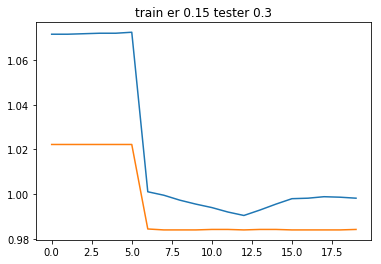

0.15 0.4
er er
value 45.62 48.3


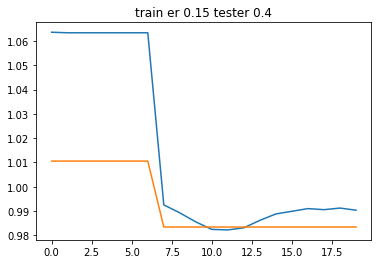

0.15 0.5
er er
value 45.5 48.9


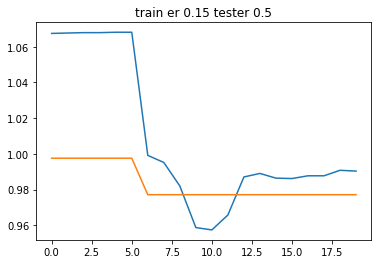

0.15 0.6
er er
value 45.42 49.14


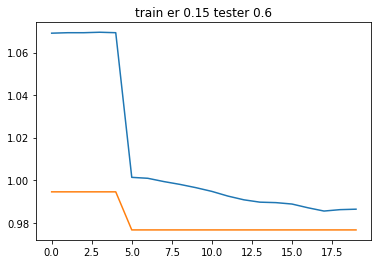

0.15 0.15
er ba
value 45.4 47.06


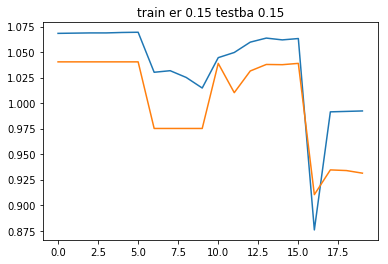

0.15 0.3
er ba
value 45.32 42.0


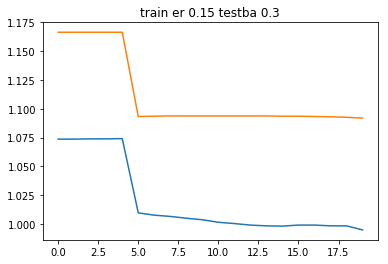

0.15 0.4
er ba
value 45.66 40.0


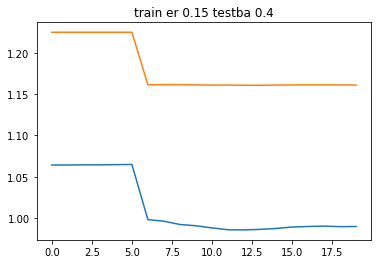

0.15 0.5
er ba
value 45.84 38.0


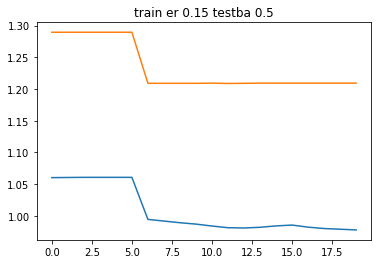

0.15 0.6
er ba
value 45.66 36.0


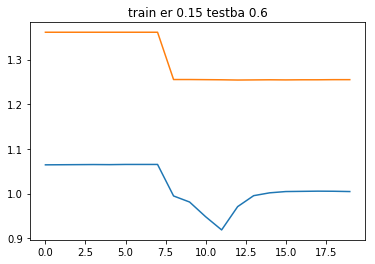

0.3 0.15
er er
value 47.8 45.48


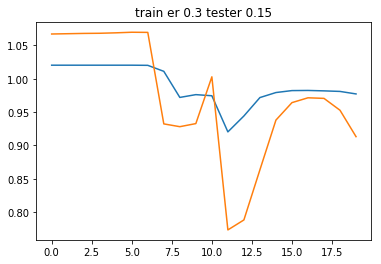

0.3 0.4
er er
value 47.76 48.36


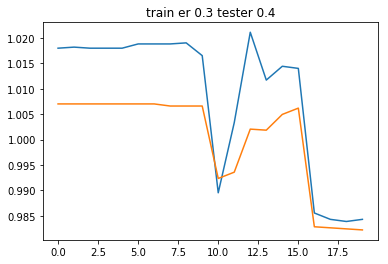

0.3 0.5
er er
value 47.84 48.74


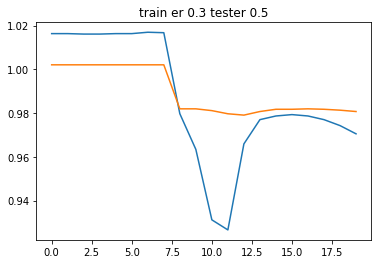

0.3 0.6
er er
value 47.72 49.16


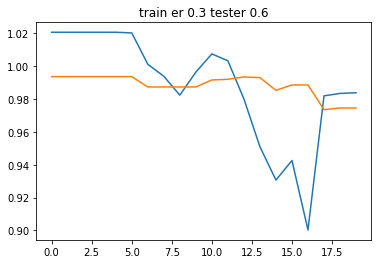

0.3 0.15
er ba
value 47.74 47.02


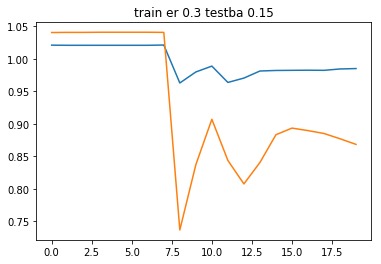

0.3 0.3
er ba
value 47.64 42.04


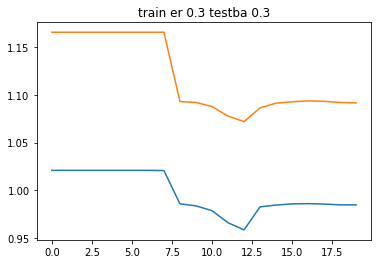

0.3 0.4
er ba
value 47.82 40.0


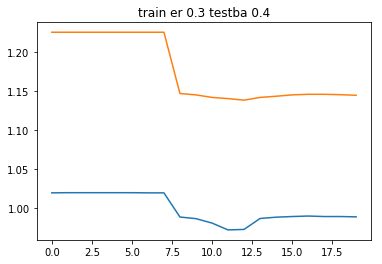

0.3 0.5
er ba
value 48.0 38.0


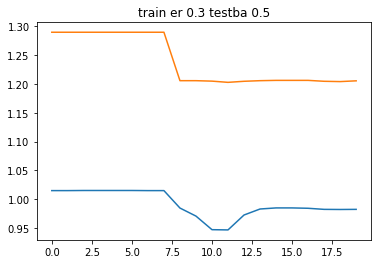

0.3 0.6
er ba
value 47.72 36.0


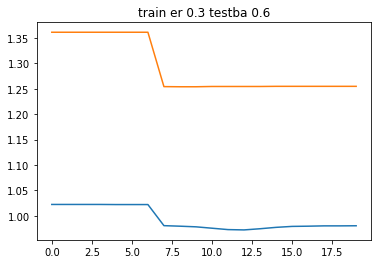

0.4 0.15
er er
value 48.44 45.62


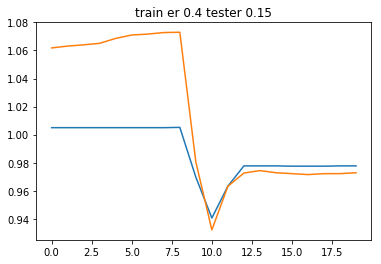

0.4 0.3
er er
value 48.38 48.0


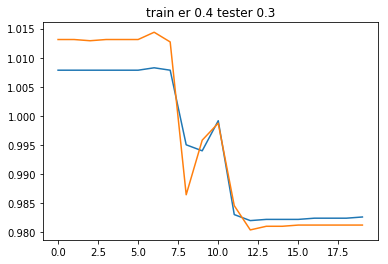

0.4 0.5
er er
value 48.28 48.72


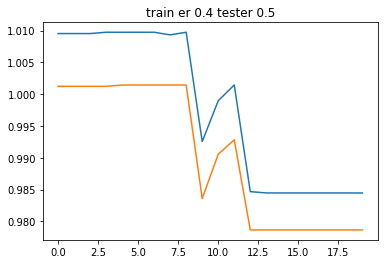

0.4 0.6
er er
value 48.7 49.0


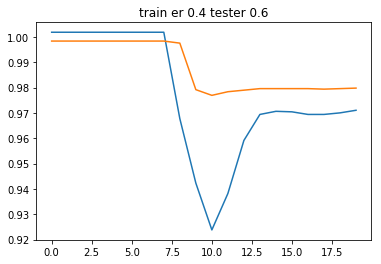

0.4 0.15
er ba
value 48.14 47.06


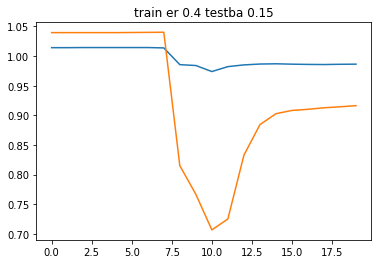

0.4 0.3
er ba
value 48.48 42.0


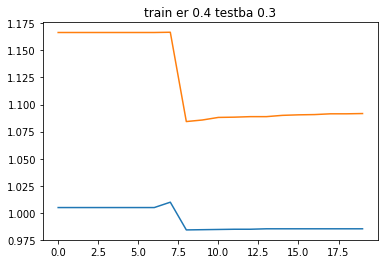

0.4 0.4
er ba
value 48.36 40.0


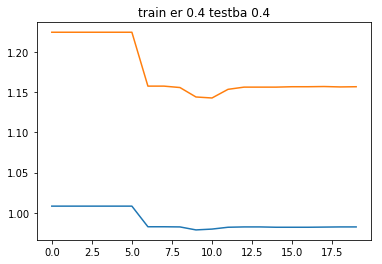

0.4 0.5
er ba
value 48.26 38.0


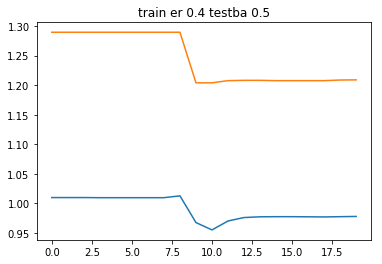

0.4 0.6
er ba
value 48.4 36.0


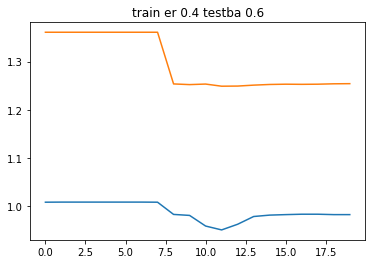

0.5 0.15
er er
value 48.9 45.36


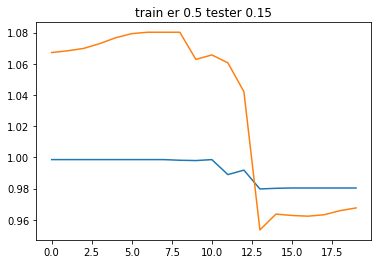

0.5 0.3
er er
value 48.94 47.86


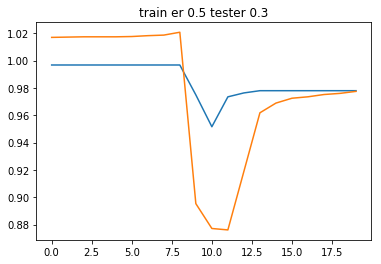

0.5 0.4
er er
value 48.62 48.34


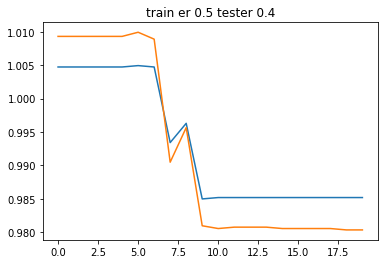

0.5 0.6
er er
value 49.08 49.14


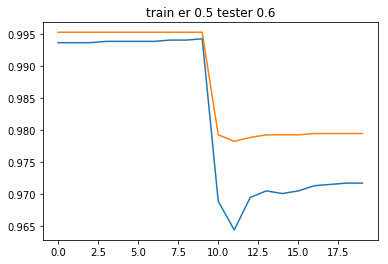

0.5 0.15
er ba
value 48.6 46.94


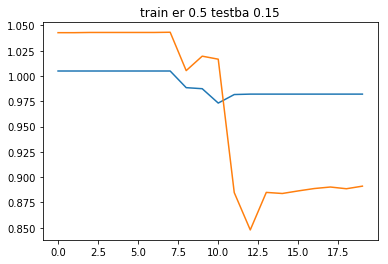

0.5 0.3
er ba
value 48.86 42.02


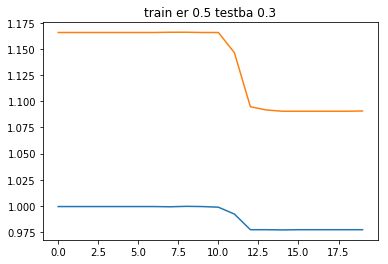

0.5 0.4
er ba
value 48.84 40.02


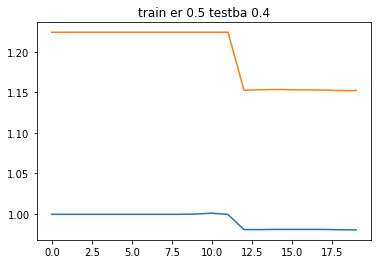

0.5 0.5
er ba
value 48.78 38.0


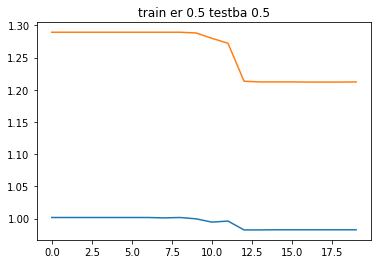

0.5 0.6
er ba
value 48.76 36.0


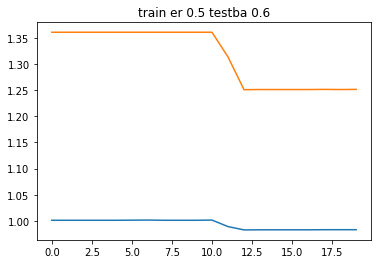

0.6 0.15
er er
value 49.06 45.36


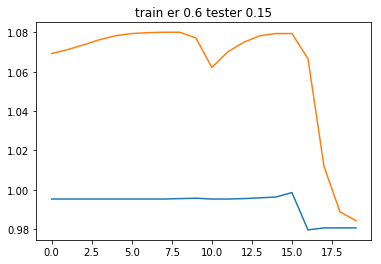

0.6 0.3
er er
value 49.02 47.66


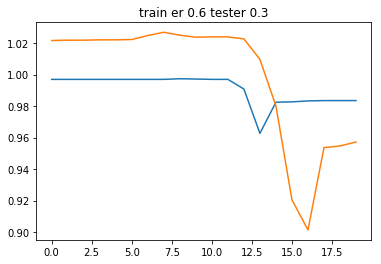

0.6 0.4
er er
value 48.98 48.5


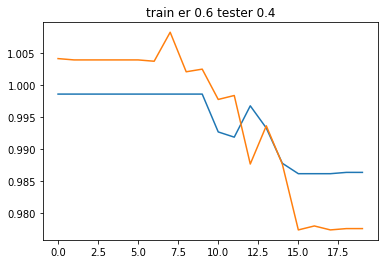

0.6 0.5
er er
value 49.02 48.88


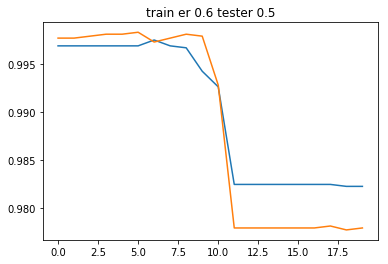

0.6 0.15
er ba
value 49.2 46.74


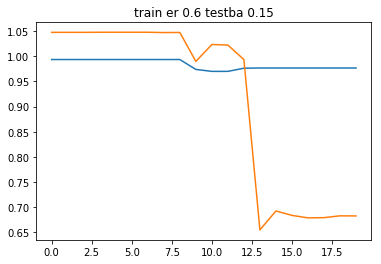

0.6 0.3
er ba
value 48.98 42.02


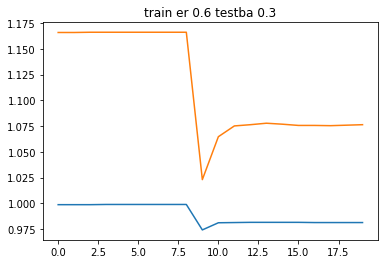

0.6 0.4
er ba
value 49.16 40.0


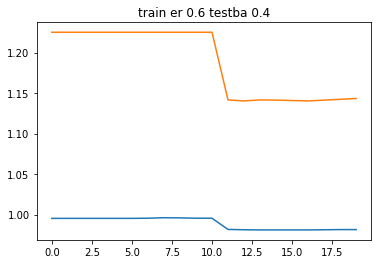

0.6 0.5
er ba
value 49.14 38.0


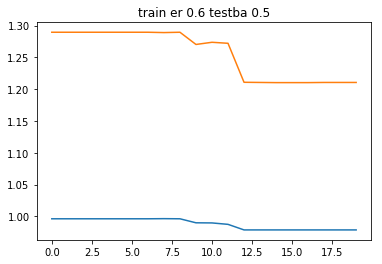

0.6 0.6
er ba
value 49.24 36.0


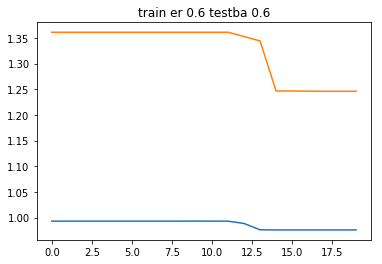

0.15 0.15
ba er
value 47.04 45.6


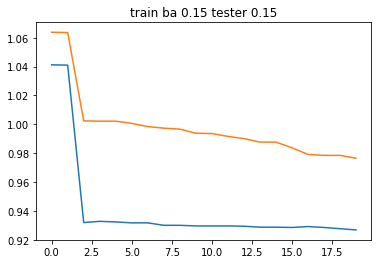

0.15 0.3
ba er
value 46.96 47.74


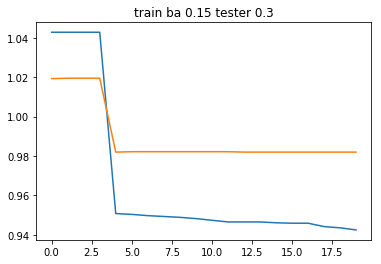

0.15 0.4
ba er
value 47.1 48.4


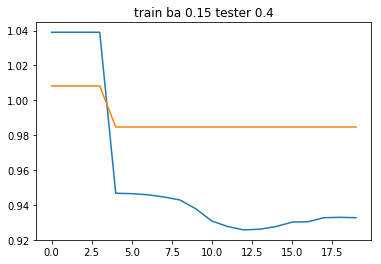

0.15 0.5
ba er
value 47.02 48.92


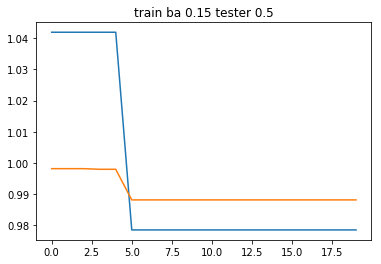

0.15 0.6
ba er
value 47.12 49.26


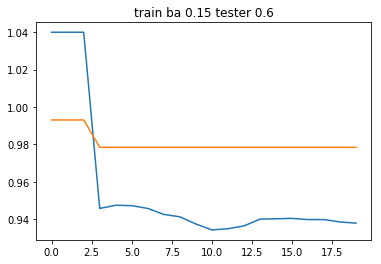

0.15 0.3
ba ba
value 46.78 42.0


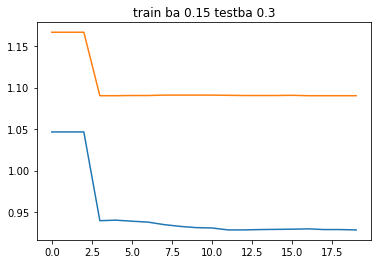

0.15 0.4
ba ba
value 46.8 40.0


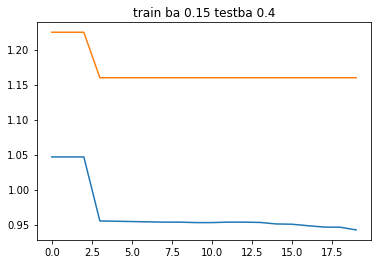

0.15 0.5
ba ba
value 46.94 38.0


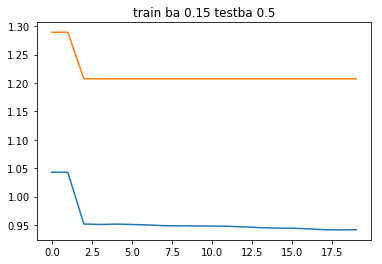

0.15 0.6
ba ba
value 46.92 36.0


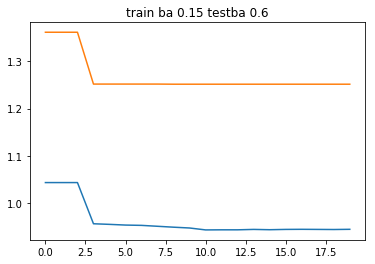

0.3 0.15
ba er
value 42.02 45.52


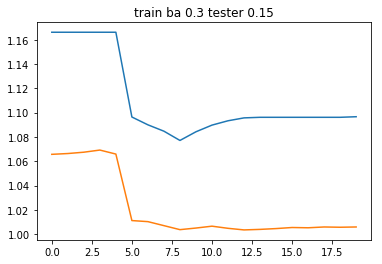

0.3 0.3
ba er
value 42.02 47.76


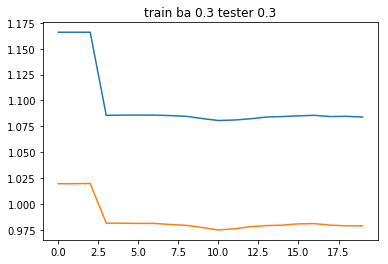

0.3 0.4
ba er
value 42.0 48.34


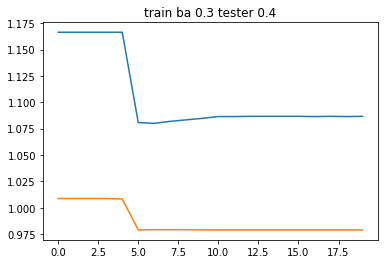

0.3 0.5
ba er
value 42.02 48.62


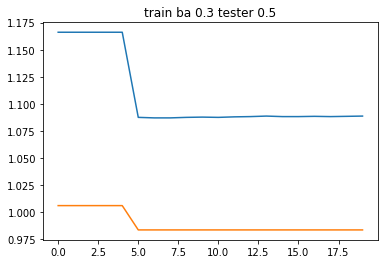

0.3 0.6
ba er
value 42.0 49.22


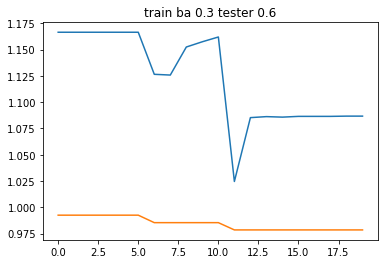

0.3 0.15
ba ba
value 42.02 47.02


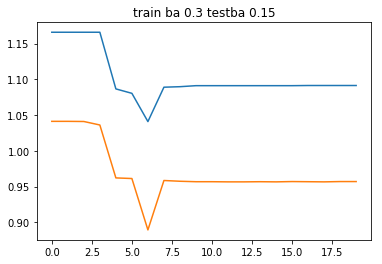

0.3 0.4
ba ba
value 42.0 40.0


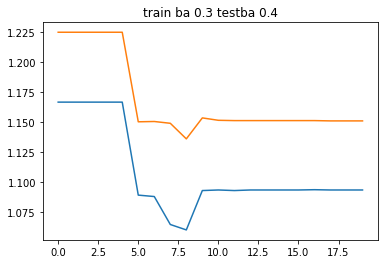

0.3 0.5
ba ba
value 42.02 38.0


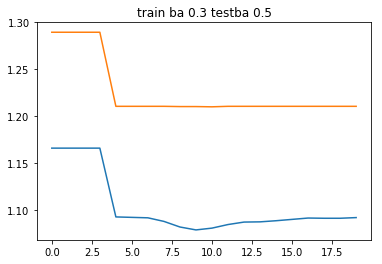

0.3 0.6
ba ba
value 42.0 36.0


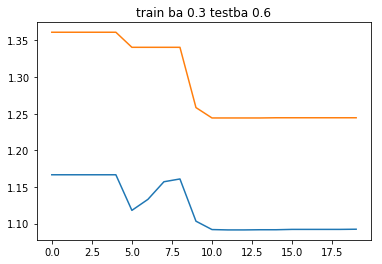

0.4 0.15
ba er
value 40.0 45.58


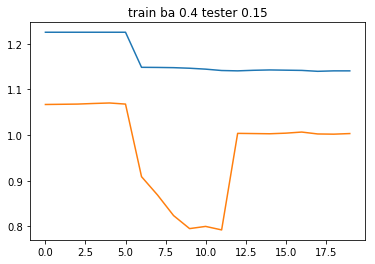

0.4 0.3
ba er
value 40.0 47.88


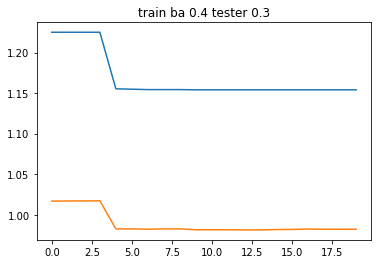

0.4 0.4
ba er
value 40.0 48.36


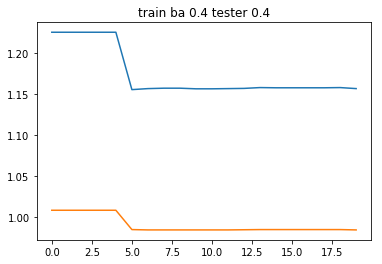

0.4 0.5
ba er
value 40.0 48.78


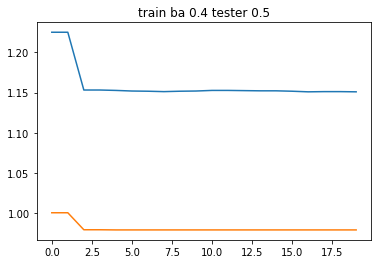

0.4 0.6
ba er
value 40.0 49.1


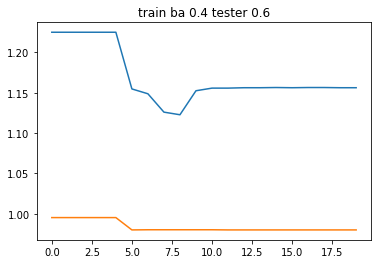

0.4 0.15
ba ba
value 40.0 47.26


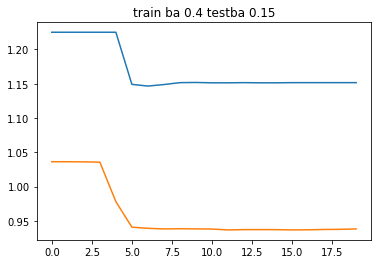

0.4 0.3
ba ba
value 40.0 42.0


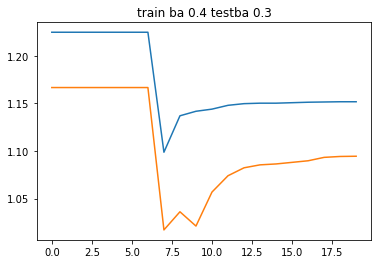

0.4 0.5
ba ba
value 40.0 38.0


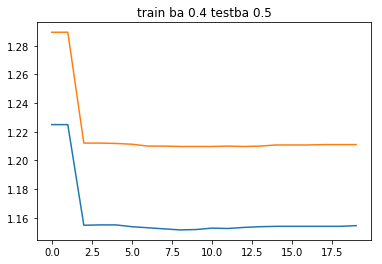

0.4 0.6
ba ba
value 40.0 36.0


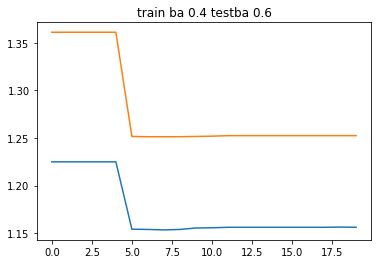

0.5 0.15
ba er
value 38.0 45.32


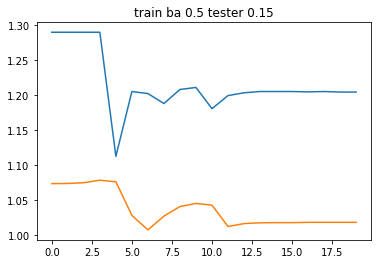

0.5 0.3
ba er
value 38.0 47.78


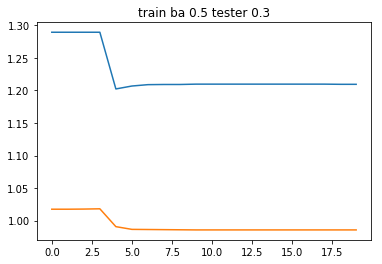

0.5 0.4
ba er
value 38.0 48.3


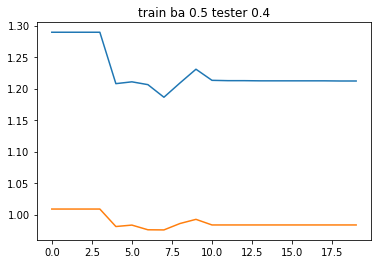

0.5 0.5
ba er
value 38.0 48.64


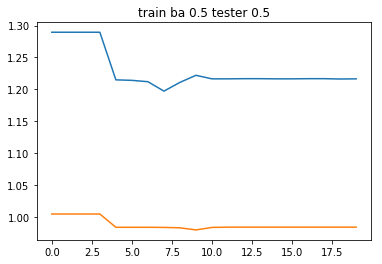

0.5 0.6
ba er
value 38.0 49.08


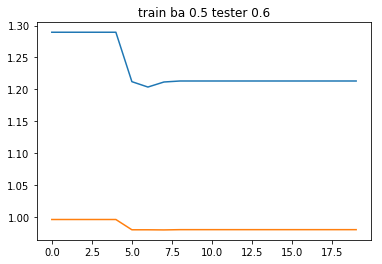

0.5 0.15
ba ba
value 38.0 47.14


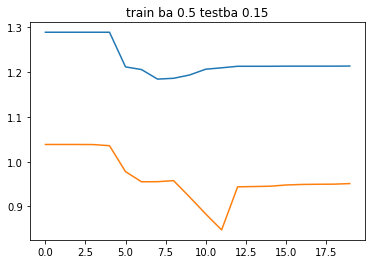

0.5 0.3
ba ba
value 38.0 42.0


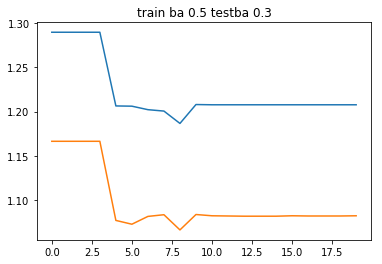

0.5 0.4
ba ba
value 38.0 40.0


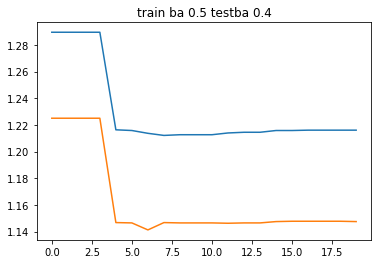

0.5 0.6
ba ba
value 38.0 36.0


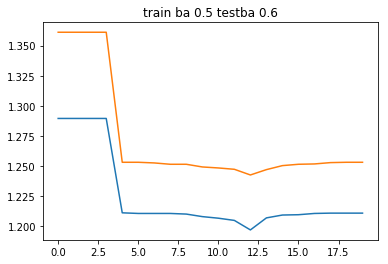

0.6 0.15
ba er
value 36.0 45.52


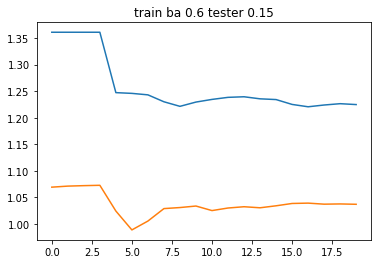

0.6 0.3
ba er
value 36.0 47.76


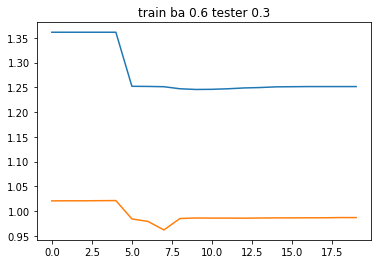

0.6 0.4
ba er
value 36.0 48.56


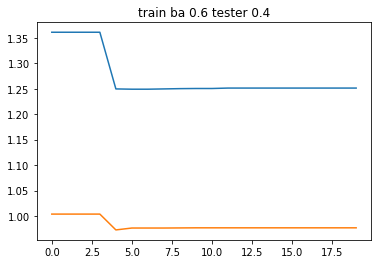

0.6 0.5
ba er
value 36.0 48.76


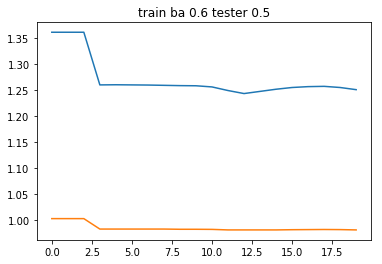

0.6 0.6
ba er
value 36.0 49.16


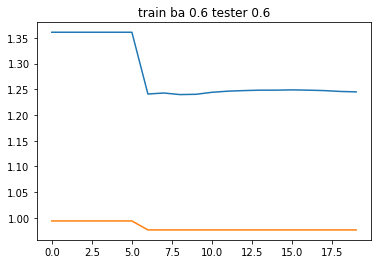

0.6 0.15
ba ba
value 36.0 46.96


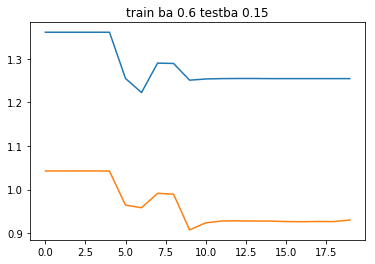

0.6 0.3
ba ba
value 36.0 42.02


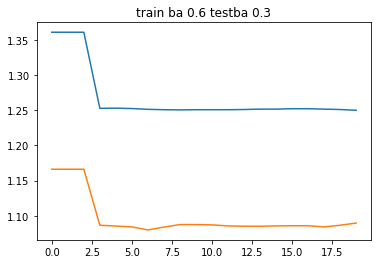

0.6 0.4
ba ba
value 36.0 40.0


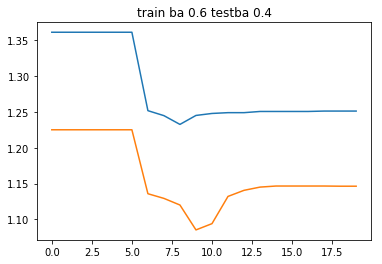

0.6 0.5
ba ba
value 36.0 38.0


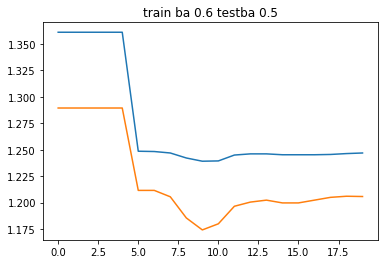

In [209]:
graph_size_list = [50]
graph_type_list = ['er' , 'ba']
density_list = [0.15,0.3,0.4,0.5,0.6]

parameter_list = list(itertools.product(graph_size_list , graph_type_list ,density_list))
N = len(parameter_list)
ct = 0
for i in range(N):
    for j in range(N):
        if i == j:
            continue
            
        gs = parameter_list[i][0]
        pa = parameter_list[i]
        pb = parameter_list[j]
        a , b = test_with_para(gs , pa[1],pa[2] , pb[1],pb[2])
        plt.plot(a)
        plt.plot(b)
        plt.title('train {} {} test{} {}'.format(pa[1],pa[2],pb[1],pb[2]))
        plt.show()
        

In [151]:
val_1 , val_2 , reward_history = training_validation(validation_graph , validation_graph_another 
                                    ,num_validation=20 , validation_per_epoch=10 , type_train='ba',
                                   er_p=0.15,ba_m = 8 , graph_size=graph_size)

density 0.1486868686868687 0.058787878787878785
value 92.04 92.52


C:\Users\Nacujachu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


0.28523932762063864 0.8180554911158628
2.4440287819506827 0.6809723136230937
5.556876456904769 0.5680449344784162
9.499922545269829 0.47626532651920006
14.81366206825678 0.403139083857126
16.268365523716486 0.34349540538927237
22.81542570289265 0.29353532030592117
26.09389676219209 0.2519584502868637
27.022986620970002 0.21741269384392303
28.385107240226144 0.1881668461020849
20.40970973670539 0.1646245476927008
12.26194487168373 0.14520781079470518
6.384924007760578 0.12892215481691519
0.8893535209238158 0.11554008791042855
0.563941886978263 0.10434007502165932
1.397294998743366 0.09509908619693425
2.0018108475394736 0.08742960559012487
1.7837958169258155 0.08113280183047217
2.0522443152261443 0.07577646804898078
2.4407815621456797 0.07123948574803632


1.029986962190352 1.0075659316904453


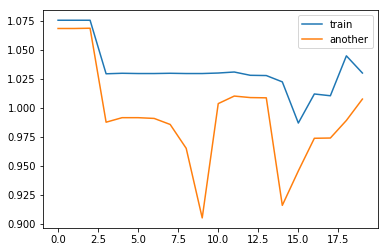

In [152]:
import matplotlib.pyplot as plt
plt.plot(val_1)
plt.plot(val_2)
plt.legend(['train','another'])
print(val_1[-1] , val_2[-1])

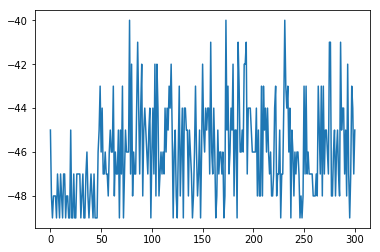

In [149]:
plt.plot(reward_history)

In [202]:
#torch.save(dqn.state_dict(), 'trained_model/MVC_ER_n{}.pkl'.format(graph_size))
#pickle_save(validation_result , 'validation_result/MVC_ER_n{}_ER.pkl'.format(graph_size))
#pickle_save(ba_result , 'validation_result/MVC_ER_n{}_BA.pkl'.format(graph_size))